In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import yfinance as yf # Dataset import
import matplotlib.pyplot as plt #Graph

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Objective**

This notebook explores how volatility regimes impact return behavior. The hypothesis is that markets behave structurally different under high and low volatility states.

**Methodology**

* Rolling 21-day annualized volatility

* Regime classification based on median threshold

* Strategy active only in low volatility regime

* Performance comparison using cumulative returns and Sharpe ratio

**Observation**

* The results highlight how regime filtering can improve risk-adjusted performance by avoiding unstable market periods.

* Further refinement could include:

* Adaptive thresholds

* Position sizing models

* Transaction cost adjustment

* Multi-factor regime classification

In [18]:
# 1. Download Market Data
symbol = "SPY"
data = yf.download(symbol, start="2010-01-01")
data['Returns'] = data['Close'].pct_change()

/tmp/ipykernel_55/4204200742.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start="2010-01-01")
[*********************100%***********************]  1 of 1 completed


**2. Rolling Volatility**

In [19]:
data['RollingVol'] = data['Returns'].rolling(21).std() * np.sqrt(252) #252 for 1 Year working days

**3. Volatility Regime Classification**

In [20]:
vol_threshold = data['RollingVol'].median()
data['Regime'] = np.where(data['RollingVol'] > vol_threshold, "High Vol", "Low Vol")

**4. Simple Regime-Based Strategy**

In [21]:
data['Strategy'] = np.where(data['Regime'] == "Low Vol", data['Returns'], 0)

**5. Cumulative Returns**

In [22]:
data['Cumulative Market'] = (1 + data['Returns']).cumprod()
data['Cumulative Strategy'] = (1 + data['Strategy']).cumprod()

**6. Performance Metrics**

In [23]:
def sharpe_ratio(series):
    return np.sqrt(252) * series.mean() / series.std()

market_sharpe = sharpe_ratio(data['Returns'].dropna())
strategy_sharpe = sharpe_ratio(data['Strategy'].dropna())

print("Market Sharpe:", round(market_sharpe, 2))
print("Strategy Sharpe:", round(strategy_sharpe, 2))

Market Sharpe: 0.84
Strategy Sharpe: 0.94


**7. Plot**

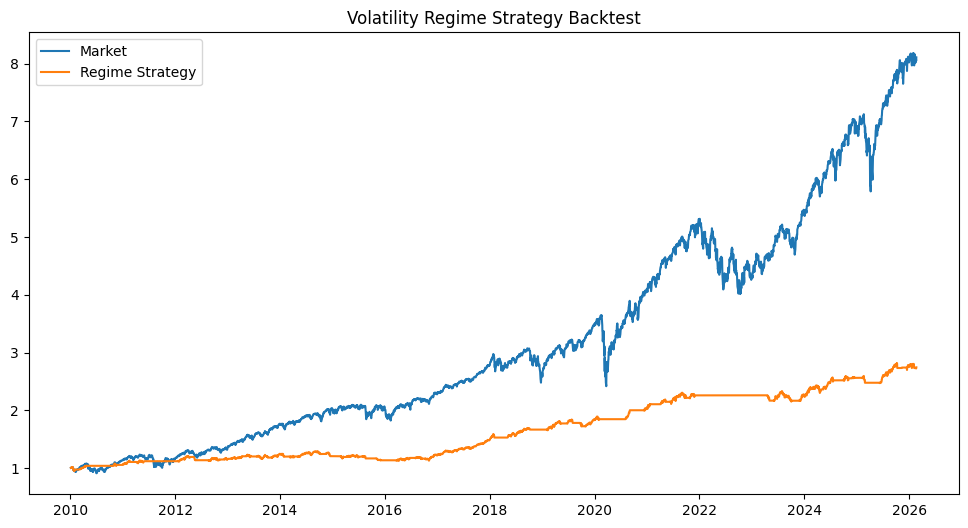

In [24]:
plt.figure(figsize=(12,6))
plt.plot(data['Cumulative Market'], label='Market')
plt.plot(data['Cumulative Strategy'], label='Regime Strategy')
plt.legend()
plt.title("Volatility Regime Strategy Backtest")
plt.show()